In [168]:
import numpy as np
import matplotlib.pyplot as plt
from simulation_functions import *
from tqdm import tqdm
from scipy.integrate import solve_ivp

In [169]:
def load_3d_matrix_from_csv(csv_file_path):
    matrix_slices = []
    current_slice = []
    
    with open(csv_file_path, 'r') as csv_file:
        for line in csv_file:
            if line.strip():  # Non-empty line
                if line.startswith("Depth"):
                    if current_slice:
                        matrix_slices.append(current_slice)
                        current_slice = []
                else:
                    values = line.strip().split(',')
                    current_slice.append(list(map(float, values)))  # Change int to float
    
    if current_slice:
        matrix_slices.append(current_slice)
    
    matrix_3d = np.array(matrix_slices)
    return matrix_3d

In [2]:
def n_f_dist(n_f,n_p):
    return np.linalg.norm(n_f-n_p)/np.linalg.norm(n_f)

In [3]:
def evaluate_fitness_controlled(k,K,n_f,lam,lam_c,s_hat,m,t_f):
    dists = []
    for i in range(m):
        lam_p = np.zeros(g) 
        #idx = np.random.randint(5)
        lam_p[i] = lam_p[i]+2
        nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
        dists.append(n_f_dist(n_f,nt[:,-1]))
    return np.mean(dists)

In [4]:
def calc_dndt_controlled(k,K,n,n_f,lam,lam_p,lam_c,s_hat):
    s = np.dot(s_hat,n - n_f)
    return np.matmul(k*(np.outer(np.ones(len(n)),n)+ K)**(-1),n) - lam*n - lam_p*n - s*lam_c#*n

In [5]:
def sim_dyn(n0,t_f,k,K,lam):
    def dndt(t,n):
        output = calc_dndt(k,K,n,lam)
        return output
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    sol = solve_ivp(dndt, t_span, n0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    n_eval = sol_fun(t_eval)
    return n_eval, t_eval


In [6]:
def sim_dyn_controlled(n0,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat):
    def dndt(t,n):
        output = calc_dndt_controlled(k,K,n,n_f,lam,lam_p,lam_c,s_hat)
        return output
    t_span = [0, t_f]  # Time span to solve the differential equation
    rtol = 1e-6  # Relative tolerance for the solution
    atol = 1e-9  # Absolute tolerance for the solution
    sol = solve_ivp(dndt, t_span, n0, rtol=rtol, atol=atol, dense_output=True, method='Radau')

    # Create an interpolating function for the solution
    sol_fun = sol.sol

    # Evaluate the solution at a large number of time points for plotting
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    n_eval = sol_fun(t_eval)
    return n_eval, t_eval


In [26]:
def plot_eigenvectors(v,nt,n_f,v_0_idx = 0, v_f_idx = 5):
    for i in range(v_0_idx,v_f_idx):#v.shape[0]):
        v_plot = np.dot(v[:,i],nt)
        n_f_v = np.dot(v[:,i],n_f)
        #v_plot = v_plot - v_plot[-1]
        v_plot = v_plot - n_f_v
        if i == 0:
            plt.plot(t,v_plot,'--',label = 'Slow Mode')
            plt.legend()
        else:
            plt.plot(t,v_plot)

In [30]:
#no slow mode
g = 30
lam = 5
lam = np.zeros(g)+lam
is_connected = np.random.rand(g,g) < .25
is_connected = np.tril(is_connected, k=-1)
is_connected = is_connected + np.transpose(is_connected)
k = np.multiply(is_connected,np.random.rand(g,g))
K = np.multiply(is_connected,np.random.rand(g,g))
t_f = 200
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f,k,K,lam)
n_f = nt[:,-1]

In [21]:
g = 30
lam = 5
lam = np.zeros(g)+lam
k = np.genfromtxt('k.csv', delimiter=',')
K = data = np.genfromtxt('kk.csv', delimiter=',')
t_f = 200
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f,k,K,lam)
n_f = nt[:,-1]
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)

In [117]:
t_f = 2

k_p = np.array(k)
mut_idx = np.random.randint(len(np.nonzero(k_p)[0]))
k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]] = k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]]*10**(2*np.random.rand()-1)
nt, t = sim_dyn(n_f,t_f,k_p,K,lam)

Text(0.5, 0, 'Time')

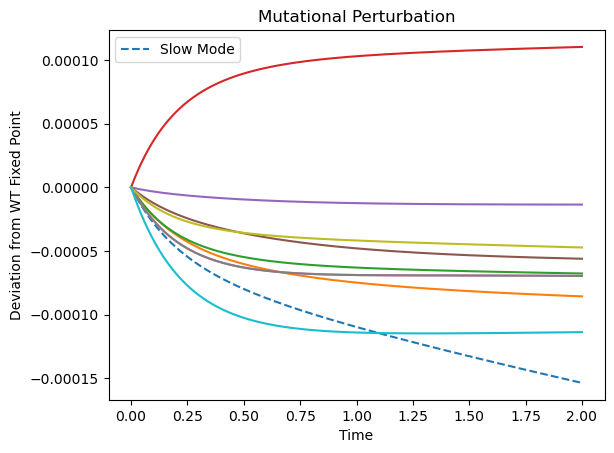

In [118]:
plot_eigenvectors(v,nt,n_f)
plt.ylabel('Deviation from WT Fixed Point')
plt.title('Mutational Perturbation')
plt.xlabel('Time')

In [11]:
t_f = 400

lam_c = np.zeros(g)
s_hat = np.zeros(g)
lam_p = np.zeros(g) 
idx = np.random.randint(g)
lam_p[idx] = lam_p[idx]+4
nt, t = sim_dyn_controlled(n_0,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
plot_eigenvectors(v,nt,n_f)
plt.ylabel('Deviation from WT Fixed Point')
plt.title('Environmental Perturbation (perturbed n)')
plt.xlabel('Time')

NameError: name 'n_0' is not defined

In [89]:
lam_p

array([0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [506]:
k[np.nonzero(k)[0][1],np.nonzero(k)[1][1]]

0.0816258370911825

In [13]:
t_f = 25
lam_p = np.zeros(g) 
lam_p[5] = lam_p[5]+2
lam_c = np.random.rand(g)-0.5
s_hat = np.random.rand(g)-0.5
s_hat = s_hat/np.linalg.norm(s_hat)

nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)


In [14]:
plot_eigenvectors(v,nt,n_f)


NameError: name 'v' is not defined

In [46]:
t_f = 5
m = 4
T = .1
g = len(lam)
lam_c = np.random.rand(g)-0.5
s_hat = np.random.rand(g)-0.5
s_hat = s_hat/np.linalg.norm(s_hat)

fitness = evaluate_fitness_controlled(k,K,n_f,lam,lam_c,s_hat,m,t_f)
fitnesses = [fitness]
went_downhill = 0 

for i in tqdm(range(100000)):
    
    i, j = np.random.randint(g), np.random.randint(g)
    
    lam_c_new = np.array(lam_c)
    lam_c_new[i] = lam_c_new[i] + (np.random.rand() - 0.5)*4/10

    s_hat_new = np.array(s_hat)
    s_hat_new[j] = s_hat_new[j] + (np.random.rand() - 0.5)*4/10
    s_hat_new = s_hat_new/np.linalg.norm(s_hat_new)
    
    fitness_new = evaluate_fitness_controlled(k,K,n_f,lam,lam_c_new,s_hat_new,m,t_f)

    if fitness_new < fitness:
        fitness = fitness_new
        s_hat = s_hat_new
        lam_c = lam_c_new
    elif np.exp((fitness_new-fitness)/T) < np.random.rand():
        fitness = fitness_new
        s_hat = s_hat_new
        lam_c = lam_c_new
        went_downhill = went_downhill + 1
    fitnesses.append(fitness)
    

  1%|▏                          | 904/100000 [00:59<1:48:59, 15.15it/s]


KeyboardInterrupt: 

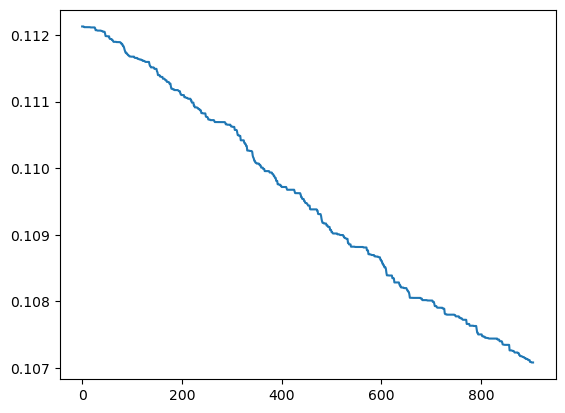

In [47]:
evaluate_fitness_controlled(k,K,n_f,lam,lam_c,s_hat,m,t_f)

In [15]:
def simulated_annealing(k,K,n_f,lam,lam_c_0,s_hat_0,m,t_f, num_iterations, temperature, cooling_rate):
    best_s_hat = lam_c_0
    best_lam_c = s_hat_0
    best_cost = evaluate_fitness_controlled(k,K,n_f,lam,best_lam_c,best_s_hat,m,t_f)

    current_s_hat = lam_c_0
    current_lam_c = s_hat_0
    current_cost = best_cost

    costs = []

    for iteration in tqdm(range(num_iterations)):
        costs.append(current_cost)
        new_s_hat = current_s_hat + np.random.normal(0, 0.2, size=current_s_hat.shape)
        new_lam_c = current_lam_c + np.random.normal(0, 0.2, size=current_lam_c.shape)

        # Ensure the Euclidean norm of new_params2 is 1
        new_s_hat /= np.linalg.norm(new_s_hat)

        new_cost = evaluate_fitness_controlled(k,K,n_f,lam,new_lam_c,new_s_hat,m,t_f)

        if new_cost < current_cost:
            current_s_hat = new_s_hat
            current_lam_c = new_lam_c
            current_cost = new_cost

            if new_cost < best_cost:
                best_s_hat = new_s_hat
                best_lam_c = new_lam_c
                best_cost = new_cost
        else:
            probability = np.exp((current_cost - new_cost) / temperature)
            if np.random.random() < probability:
                current_s_hat = new_s_hat
                current_lam_c = new_lam_c
                current_cost = new_cost

        temperature *= cooling_rate
        #if iteration/100 ==0 :
            #print(current_cost)
    return best_s_hat, best_lam_c, costs

In [148]:
ks = load_3d_matrix_from_csv("many_ks.csv")
Ks = load_3d_matrix_from_csv("many_KKs.csv")

array([[0.        , 0.54979998, 0.33244851, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.32429433, 0.        , 0.        ,
        0.91081435, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.24708621,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.7929173 , 0.        , 0.90323487, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.19714054, 0.        ,
        0.        , 0.81399266, 0.        , 0.71058613, 0.        ,
        0.        , 0.        , 0.76248395, 0.        , 0.        ,
        0.        , 0.        , 0.57411424, 0.        , 0.        ,
        0.49117398, 0.        , 0.        , 0.        , 0.        ],
       [0.85071939, 0.98205033, 0.        , 0.        , 0.95411134,
        0.34298703, 0.        , 0.        , 0.        , 0.25722913,
        0.        , 0.        , 0.        , 0.

In [160]:
K = Ks[-5,:,:]
k = ks[-5,:,:]

t_f = 200
n0 = np.zeros(g) + 0.5
nt, t = sim_dyn(n0,t_f,k,K,lam)
n_f = nt[:,-1]
J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)

t_f = 5
m = 20
g = len(lam)
lam_c_0 = np.random.rand(g)-0.5 
s_hat_0 = np.random.rand(g)-0.5 
s_hat_0 = s_hat/np.linalg.norm(s_hat)
temperature = 1.0
cooling_rate = 0.96
num_iterations = 1000
best_s_hat, best_lam_c, costs = simulated_annealing(k,K,n_f,lam,lam_c_0,s_hat_0,m,t_f, num_iterations, temperature, cooling_rate)

100%|██████████████████████████████████████| 1000/1000 [03:40<00:00,  4.53it/s]


In [162]:
evaluate_fitness_controlled(k,K,n_f,lam,best_lam_c,best_s_hat,m,t_f)/np.linalg.norm(1/w)

0.0008995784709363232

In [159]:
evaluate_fitness_controlled(k,K,n_f,lam,best_lam_c,best_s_hat,m,t_f)/np.linalg.norm(1/w)

0.0005920951254193551

In [157]:
evaluate_fitness_controlled(k,K,n_f,lam,best_lam_c,best_s_hat,m,t_f)/np.linalg.norm(1/w)

0.027144283635949944

In [156]:
np.linalg.norm(1/w)

2.148712661807865

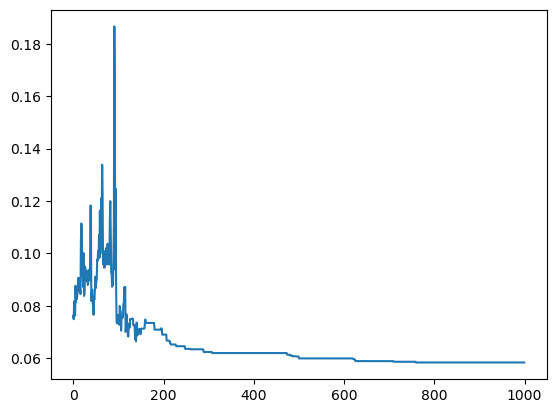

In [151]:
plt.plot(costs)

5


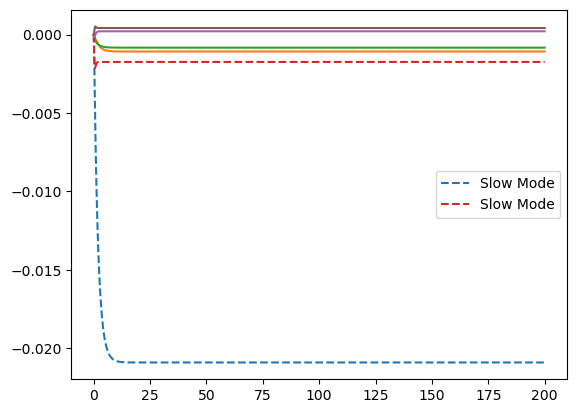

In [154]:
idx = np.random.randint(g)
print(idx)
t_f = 200
lam_p = np.zeros(g) 
lam_p[idx] = lam_p[idx]+2
lam_c = np.zeros(g) 
s_hat = np.zeros(g) 

nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
plot_eigenvectors(v,nt,n_f,v_0_idx = 0, v_f_idx = 3)
t_f = 200
lam_p = np.zeros(g) 
lam_p[idx] = lam_p[idx]+2
lam_c = best_lam_c
s_hat = best_s_hat 

nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
plot_eigenvectors(v,nt,n_f,v_0_idx = 0, v_f_idx = 3)

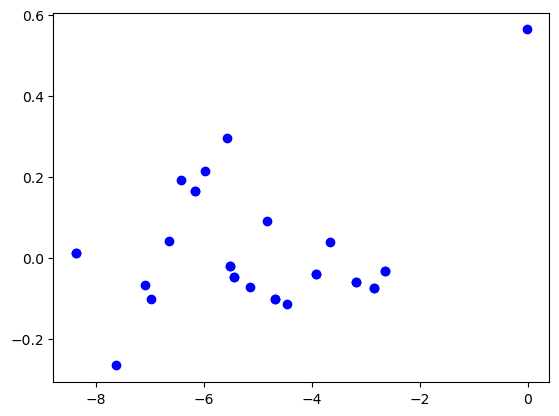

In [163]:
for i in range(0,g):
        v_plot = np.dot(v[:,i],best_s_hat)
        plt.scatter(w[i],v_plot,color = 'b')

In [117]:
dists = []
m = 25
for i in range(m):
    lam_p = np.zeros(g) 
    lam_p[i] = lam_p[i]+2
    nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
    dists.append(nt[:,-1])
dists_no_doc = []
m = 25
for i in range(m):
    lam_p = np.zeros(g) 
    lam_p[i] = lam_p[i]+2
    nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,np.zeros(g),np.zeros(g))
    dists_no_doc.append(nt[:,-1])

In [118]:
dists_no_doc

[array([0.00062429, 0.00146445, 0.00185041, 0.0007544 , 0.00244551,
        0.00212873, 0.00204542, 0.00096608, 0.00159162, 0.00165148,
        0.00453237, 0.00284587, 0.00109733, 0.00504978, 0.00309335,
        0.00415711, 0.00083294, 0.0023256 , 0.00309221, 0.00329827,
        0.00196781, 0.00159483, 0.00138885, 0.002702  , 0.00219412,
        0.0023593 , 0.00279513, 0.00099565, 0.00207632, 0.00358059]),
 array([0.00114886, 0.00129771, 0.00233343, 0.00094139, 0.0030751 ,
        0.00262627, 0.00267472, 0.00111099, 0.00200592, 0.00209873,
        0.0057465 , 0.0035529 , 0.00132476, 0.00639344, 0.0039801 ,
        0.00526052, 0.00105822, 0.00293802, 0.00388052, 0.00416188,
        0.00250872, 0.00199044, 0.00175062, 0.0034358 , 0.00277334,
        0.00301301, 0.00352446, 0.00122269, 0.00278024, 0.00454986]),
 array([0.00017063, 0.00028412, 0.00024625, 0.0001434 , 0.0004698 ,
        0.00041723, 0.00038409, 0.0001881 , 0.00030023, 0.00031017,
        0.00086856, 0.00055393, 0.00021531, 

In [119]:
from sklearn.decomposition import PCA



# Perform PCA
pca = PCA(n_components=15)  # Reduce to 2 principal components for visualization
data_pca = pca.fit_transform(np.array(dists_no_doc))

# Print explained variance ratios
print("Explained Variance Ratios:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_))
no_doc_var = pca.explained_variance_ratio_

# Perform PCA
pca = PCA(n_components=15)  # Reduce to 2 principal components for visualization
data_pca = pca.fit_transform(np.array(dists))

# Print explained variance ratios
print("Explained Variance Ratios:", pca.explained_variance_ratio_)
print("Total Variance Explained:", sum(pca.explained_variance_ratio_))
doc_var = pca.explained_variance_ratio_



Explained Variance Ratios: [9.96196914e-01 9.98399233e-04 9.16933504e-04 4.46840644e-04
 2.96058436e-04 2.64887733e-04 1.87656826e-04 1.46770703e-04
 1.30300302e-04 1.01806085e-04 7.24004906e-05 6.75717645e-05
 5.80868178e-05 3.98794719e-05 3.44794531e-05]
Total Variance Explained: 0.9999589851995736
Explained Variance Ratios: [0.28233352 0.13910858 0.1094004  0.08228524 0.06855996 0.0619358
 0.05229037 0.03597075 0.03110406 0.02235797 0.01823333 0.01583305
 0.01362468 0.0106832  0.00991991]
Total Variance Explained: 0.9536408072550948


In [120]:
np.array(dists_no_doc).shape

(25, 30)

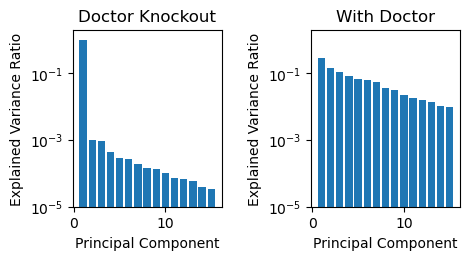

In [116]:
plt.figure(figsize=(5, 2.3))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(no_doc_var) + 1), no_doc_var)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.yscale('log')

plt.ylim([0.00001,2])

plt.title('Doctor Knockout')
plt.subplots_adjust(wspace=.6)
plt.subplot(1, 2, 2)
plt.bar(range(1, len(doc_var) + 1), doc_var)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.yscale('log')

plt.ylim([0.00001,2])
plt.yscale('log')
plt.title('With Doctor')
plt.show()

In [144]:
def evaluate_fitness_controlled_J(k,K,lam,lam_c,s_hat,m,t_f):
    n0 = np.zeros(g) + 0.5
    nt, t = sim_dyn(n0,t_f,k,K,lam)
    n_f = nt[:,-1]
    Jc = calc_J(k,K,n_f,lam)
    w, v = np.linalg.eig(Jc)
    w = np.real(w)
    dlambda = np.sort(w)[-2]/np.sort(w)[-1]
    dists = []   
    for i in range(m):
        lam_p = np.zeros(g) 
        #idx = np.random.randint(5)
        lam_p[i] = lam_p[i]+2
        nt, t = sim_dyn_controlled(n_f,t_f,k,K,n_f,lam,lam_p,lam_c,s_hat)
        dists.append(n_f_dist(n_f,nt[:,-1]))
    
    return np.mean(dists/np.linalg.norm(1/w)), dlambda

In [145]:
Jc = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(Jc)
w = np.real(w)
np.linalg.norm(1/w)

18.077128490410818

In [136]:
def simulated_annealing_J(k_0,K_0,lam,lam_c_0,s_hat_0,m,t_f, num_iterations, temperature, cooling_rate):
    best_s_hat = lam_c_0
    best_lam_c = s_hat_0
    best_K = K_0
    best_k = k_0
    best_cost, best_dlambda = evaluate_fitness_controlled_J(best_k,best_K,lam,best_lam_c,best_s_hat,m,t_f)

    current_s_hat = lam_c_0
    current_lam_c = s_hat_0
    current_K = K_0
    current_k = k_0
    current_cost = best_cost
    current_dlambda = best_dlambda

    costs = []
    dlambdas = []

    for iteration in tqdm(range(num_iterations)):
        costs.append(current_cost)
        dlambdas.append(current_dlambda)
        new_s_hat = current_s_hat + np.random.normal(0, 0.2, size=current_s_hat.shape)
        new_lam_c = current_lam_c + np.random.normal(0, 0.2, size=current_lam_c.shape)
        new_K = current_K + np.random.normal(0, 0.01, size=current_K.shape)*(current_K!=0)
        new_k = current_k + np.random.normal(0, 0.01, size=current_k.shape)*(current_k!=0)
        # Ensure the Euclidean norm of new_params2 is 1
        new_s_hat /= np.linalg.norm(new_s_hat)

        new_cost, new_dlambda = evaluate_fitness_controlled_J(new_k,new_K,lam,new_lam_c,new_s_hat,m,t_f)

        if new_cost < current_cost:
            current_s_hat = new_s_hat
            current_lam_c = new_lam_c
            current_K = new_K
            current_k = new_k
            current_cost = new_cost
            current_dlambda = new_dlambda

            if new_cost < best_cost:
                best_K = new_K
                best_k = new_k
                best_s_hat = new_s_hat
                best_lam_c = new_lam_c
                best_cost = new_cost
                best_dlambda = new_dlambda
        else:
            probability = np.exp((current_cost - new_cost) / temperature)
            if np.random.random() < probability:
                current_s_hat = new_s_hat
                current_lam_c = new_lam_c
                current_K = new_K
                current_k = new_k
                current_cost = new_cost
                current_dlambda = new_dlambda

        temperature *= cooling_rate
        #if iteration/100 ==0 :
            #print(current_cost)
    return best_s_hat, best_lam_c, best_K, best_k, costs, dlambdas

In [124]:
np.random.normal(0, 0.2, size=best_s_hat.shape)

array([-5.65482674e-03, -7.15779261e-03,  3.60185466e-02, -1.04321438e-01,
        9.31970224e-03, -4.09732327e-02,  2.50572115e-02,  1.16855914e-01,
       -7.85979321e-02, -5.41300628e-02, -2.10218125e-01, -5.88084121e-01,
       -1.44225320e-02, -8.40379206e-02,  2.50385889e-01, -1.99627846e-04,
        3.06498145e-01, -1.99964858e-01, -1.29160155e-01, -6.09186537e-02,
       -4.84704603e-01,  6.60733118e-02,  1.03227202e-01,  1.03121705e-01,
        1.94805719e-02, -2.02050052e-01,  1.17961126e-01, -2.44605714e-01,
       -8.99706137e-02, -1.76619889e-01])

In [146]:
t_f = 5
m = 20
g = len(lam)
is_connected = np.random.rand(g,g) < .25
is_connected = np.tril(is_connected, k=-1)
is_connected = is_connected + np.transpose(is_connected)
k_0 = np.multiply(is_connected,np.random.rand(g,g))
K_0 = np.multiply(is_connected,np.random.rand(g,g))
lam_c_0 = np.random.rand(g)-0.5 #np.array(0.8*v[:,0]) #
s_hat_0 = np.random.rand(g)-0.5  #np.array(v[:,0])
s_hat_0 = s_hat/np.linalg.norm(s_hat)
temperature = 1.0
cooling_rate = 0.99
num_iterations = 10000
best_s_hat, best_lam_c, best_K, best_k, costs, dlambdas = simulated_annealing_J(k_0,K_0,lam,lam_c_0,s_hat_0,m,t_f, num_iterations, temperature, cooling_rate)



  2%|▌                           | 211/10000 [01:49<3:49:52,  1.41s/it]/Users/christopher/Desktop/duality_robustness/simulation_functions.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  return np.matmul(k*(np.outer(np.ones(len(n)),n)+ K)**(-1),n) - lam*n
  6%|█▌                          | 555/10000 [11:50<4:25:58,  1.69s/it]/var/folders/yg/rz5s_kp914g5hjl723fncj_80000gn/T/ipykernel_1435/1557006956.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return np.matmul(k*(np.outer(np.ones(len(n)),n)+ K)**(-1),n) - lam*n - lam_p*n - s*lam_c#*n
 10%|██▍                     | 1040/10000 [3:24:39<29:23:11, 11.81s/it]


KeyboardInterrupt: 

In [139]:
best_s_hat, best_lam_c, best_K, best_k, costs, dlambdas

(array([-0.06229416, -0.02116417, -0.04291507, -0.31035331,  0.23576887,
        -0.00935619, -0.21533419, -0.08598086, -0.11021682,  0.29569951,
         0.22801802, -0.24357761, -0.11279649, -0.17448253, -0.28592578,
        -0.12222706,  0.20687103,  0.15934149, -0.34819405,  0.30902556,
         0.19494038, -0.09517979,  0.01508339,  0.19783801, -0.05944819,
        -0.11275902, -0.03211291,  0.16036063, -0.05535989, -0.14105482]),
 array([ 0.13867486, -0.43988005,  0.38313528,  0.24549744,  0.36013958,
        -0.08570076, -0.63372523, -0.24016725, -0.65315207,  0.22844001,
        -0.68758887, -0.14021404, -0.92420964,  0.94128476, -0.47981426,
        -0.66416244, -1.22252032,  0.0077123 , -0.50039504, -0.53556473,
         1.26120402, -0.22525605, -0.32668799, -0.03978345,  0.06170133,
        -0.38000828, -0.41822655, -0.5223937 ,  0.23171674, -0.64951174]),
 array([[ 0.        ,  0.        ,  0.        ,  0.27807861,  0.        ,
          0.        ,  0.        ,  0.        

In [ ]:
def run_simulation(k,K,lam,n):
    
    g = k.shape[0]
    dt = 0.01
    thresh = 0.0007
    steps = 500000
    nt = np.zeros((g,steps))
    for i in range(steps):
        n = n + dndt(k,K,n,lam)*dt
        nt[:,i] = n
        if i > 0 and np.sum(np.abs(n - nt[:,i-1]))/np.sum(np.abs(n)) < thresh:
            nt = nt[:,:i+1]
            break
            
    Jc = J(k,K,nt[:,i],lam)
    w, v = np.linalg.eig(Jc)
    w = np.real(w)
    dlambda = np.sort(w)[-2]/np.sort(w)[-1]
    IPR = np.sum((v[np.argsort(w)][-1] * np.conjugate(v[np.argsort(w)][-1]))**2)
    return dlambda, IPR, nt

Text(0.5, 0, 'Time')

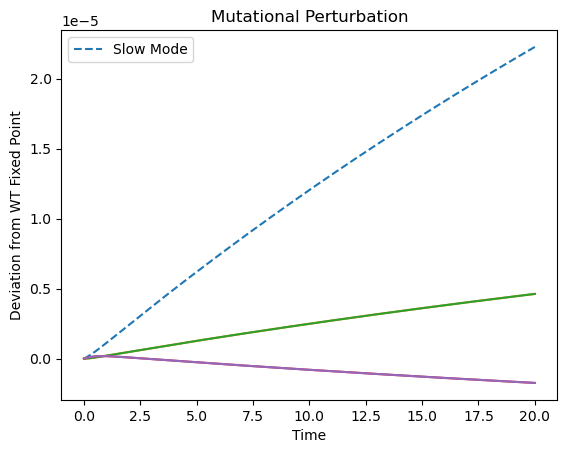

In [167]:
t_f = 20

k_p = np.array(k)
mut_idx = np.random.randint(len(np.nonzero(k_p)[0]))
k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]] = k_p[np.nonzero(k_p)[0][mut_idx],np.nonzero(k_p)[1][mut_idx]]*10**(2*np.random.rand()-1)
nt, t = sim_dyn(n_f,t_f,k_p,K,lam)
plot_eigenvectors(v,nt,n_f)
plt.ylabel('Deviation from WT Fixed Point')
plt.title('Mutational Perturbation')
plt.xlabel('Time')